In [108]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [109]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(20)

In [110]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [112]:
client

Client Scheduler: tcp://10.148.0.253:41669 Dashboard: http://10.148.0.253:8787/status,Cluster Workers: 22 Cores: 88 Memory: 1100.00 GB


---
# 1. Drifter results

In [113]:
data_dir = '/home1/datawork/xyu/Drifters/'

In [114]:
drifter_results = h5py.File(data_dir+'Drifter_results.mat','r') 
print(drifter_results)

<HDF5 file "Drifter_results.mat" (mode r)>


In [115]:
list(drifter_results.items())

[('f', <HDF5 dataset "f": shape (1, 720), type "<f8">),
 ('f_welch', <HDF5 dataset "f_welch": shape (1, 1440), type "<f8">),
 ('fbin', <HDF5 dataset "fbin": shape (1, 720), type "<f8">),
 ('msac_welch', <HDF5 dataset "msac_welch": shape (1, 720), type "<f8">),
 ('msc_welch', <HDF5 dataset "msc_welch": shape (1, 720), type "<f8">),
 ('msnn_welch', <HDF5 dataset "msnn_welch": shape (719, 120), type "<f8">),
 ('mspp_welch', <HDF5 dataset "mspp_welch": shape (719, 120), type "<f8">),
 ('xmid', <HDF5 dataset "xmid": shape (1, 719), type "<f8">),
 ('ymid', <HDF5 dataset "ymid": shape (1, 120), type "<f8">)]

In [9]:
msnn_welch = drifter_results['msnn_welch'] # negative-freq spectra (unit: m^2 s^-2 cps)
msnn_welch = np.array(msnn_welch)

mspp_welch = drifter_results['mspp_welch'] # positive-freq spectra (unit: m^2 s^-2 cps)
mspp_welch = np.array(mspp_welch)

xmid = drifter_results['xmid'] # frequencies from negative to positive (unit: 2*pi*cpd)
xmid = np.array(xmid)
xmid = xr.DataArray(xmid)

ymid = drifter_results['ymid'] # latitude
ymid = np.array(ymid)
ymid = xr.DataArray(ymid)

In [10]:
freq_positive = xr.DataArray.squeeze(xmid, dim='dim_0')
freq_negative = xr.DataArray.squeeze(-1*xmid, dim='dim_0')
lat = xr.DataArray.squeeze(ymid, dim='dim_0')

In [11]:
ds = xr.Dataset({'msnn_welch': (['freq_negative', 'lat'], msnn_welch),
                 'mspp_welch': (['freq_positive', 'lat'], mspp_welch)},
                 coords={'freq_positive': (['freq_positive'], freq_positive),
                         'freq_negative': (['freq_negative'], freq_negative),
                         'lat':(['lat'],lat)})
print(ds)

<xarray.Dataset>
Dimensions:        (freq_negative: 719, freq_positive: 719, lat: 120)
Coordinates:
  * freq_positive  (freq_positive) float64 2.894e-07 4.823e-07 6.752e-07 ...
  * freq_negative  (freq_negative) float64 -2.894e-07 -4.823e-07 -6.752e-07 ...
  * lat            (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 ...
Data variables:
    msnn_welch     (freq_negative, lat) float64 nan nan nan nan nan nan nan ...
    mspp_welch     (freq_positive, lat) float64 nan nan nan nan nan nan nan ...


## Combine positive- and negative-freq spectra

In [12]:
E_positive = xr.Dataset({'mspp_welch': (['freq', 'lat'], mspp_welch)},
                 coords={'freq': (['freq'], freq_positive),'lat':(['lat'],lat)})
print(E_positive)

<xarray.Dataset>
Dimensions:     (freq: 719, lat: 120)
Coordinates:
  * freq        (freq) float64 2.894e-07 4.823e-07 6.752e-07 8.681e-07 ...
  * lat         (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 ...
Data variables:
    mspp_welch  (freq, lat) float64 nan nan nan nan nan nan nan nan nan nan ...


In [13]:
E_negative = xr.Dataset({'msnn_welch': (['freq', 'lat'], msnn_welch)},
                 coords={'freq': (['freq'], freq_negative),'lat':(['lat'],lat)})
print(E_negative)

<xarray.Dataset>
Dimensions:     (freq: 719, lat: 120)
Coordinates:
  * freq        (freq) float64 -2.894e-07 -4.823e-07 -6.752e-07 -8.681e-07 ...
  * lat         (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 ...
Data variables:
    msnn_welch  (freq, lat) float64 nan nan nan nan nan nan nan nan nan nan ...


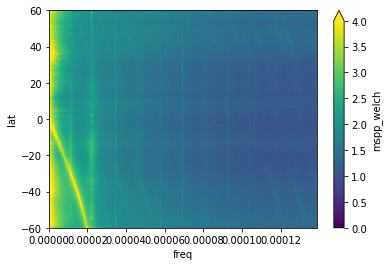

In [15]:
E1 = E_positive.mspp_welch
np.log10(E1).plot(x='freq', y='lat',vmin=0, vmax=4)

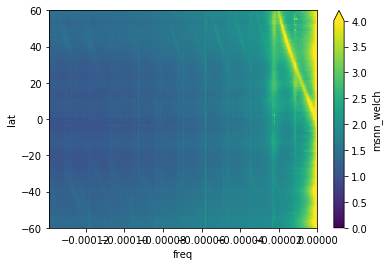

In [16]:
E2 = E_negative.msnn_welch
np.log10(E2).plot(x='freq', y='lat',vmin=0, vmax=4)

In [17]:
E_drifters = E2.combine_first(E1)
E_drifters

<xarray.DataArray (freq: 1438, lat: 120)>
array([[21.949114, 20.227203, 21.462743, ..., 23.861606, 25.006562, 24.3136  ],
       [20.929773, 21.556725, 20.897274, ..., 24.874302, 28.080545, 27.782766],
       [19.74015 , 22.054582, 21.451886, ..., 26.501141, 26.373576, 33.481859],
       ...,
       [19.008931, 21.582291, 22.902298, ..., 24.669822, 21.823514, 23.5675  ],
       [20.396791, 21.446725, 22.572544, ..., 21.914752, 24.453299, 27.108437],
       [21.071084, 21.874516, 21.831132, ..., 22.953193, 23.367088, 24.95646 ]])
Coordinates:
  * freq     (freq) float64 -0.0001388 -0.0001386 -0.0001384 -0.0001382 ...
  * lat      (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...

In [18]:
E_drifters = E_drifters.assign_coords(freq_cpd=E_drifters.freq*86400)
print(E_drifters)

<xarray.DataArray (freq: 1438, lat: 120)>
array([[21.949114, 20.227203, 21.462743, ..., 23.861606, 25.006562, 24.3136  ],
       [20.929773, 21.556725, 20.897274, ..., 24.874302, 28.080545, 27.782766],
       [19.74015 , 22.054582, 21.451886, ..., 26.501141, 26.373576, 33.481859],
       ...,
       [19.008931, 21.582291, 22.902298, ..., 24.669822, 21.823514, 23.5675  ],
       [20.396791, 21.446725, 22.572544, ..., 21.914752, 24.453299, 27.108437],
       [21.071084, 21.874516, 21.831132, ..., 22.953193, 23.367088, 24.95646 ]])
Coordinates:
  * freq      (freq) float64 -0.0001388 -0.0001386 -0.0001384 -0.0001382 ...
  * lat       (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd  (freq) float64 -11.99 -11.97 -11.96 -11.94 -11.92 -11.91 ...


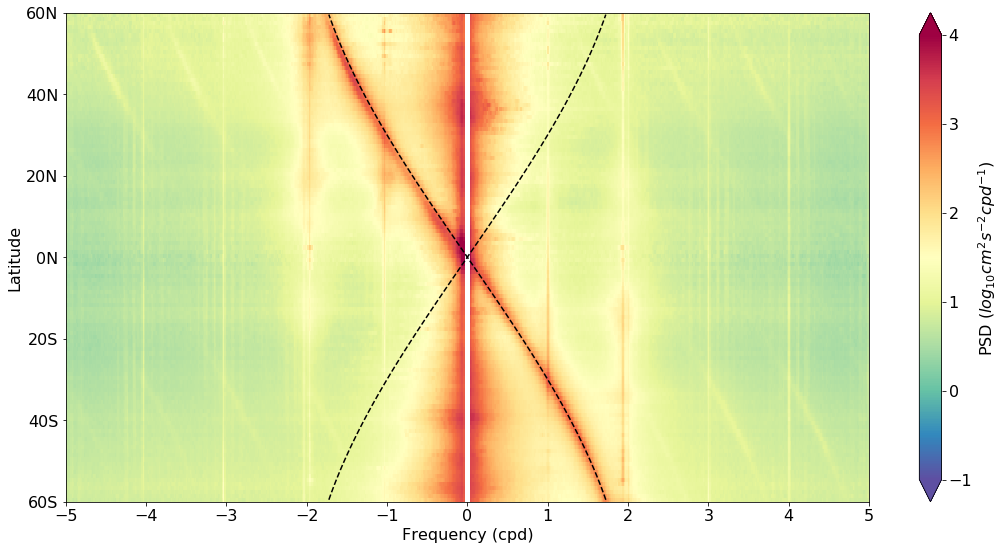

In [19]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

cax = np.log10(10000*E_drifters/86400).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifters.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_Drifters_1.png')


In [20]:
df=E_drifters.freq[1]-E_drifters.freq[0]
print(df)

<xarray.DataArray 'freq' ()>
array(1.929012e-07)


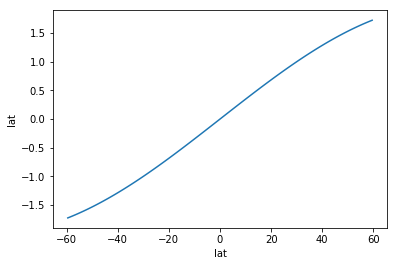

In [21]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifters.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

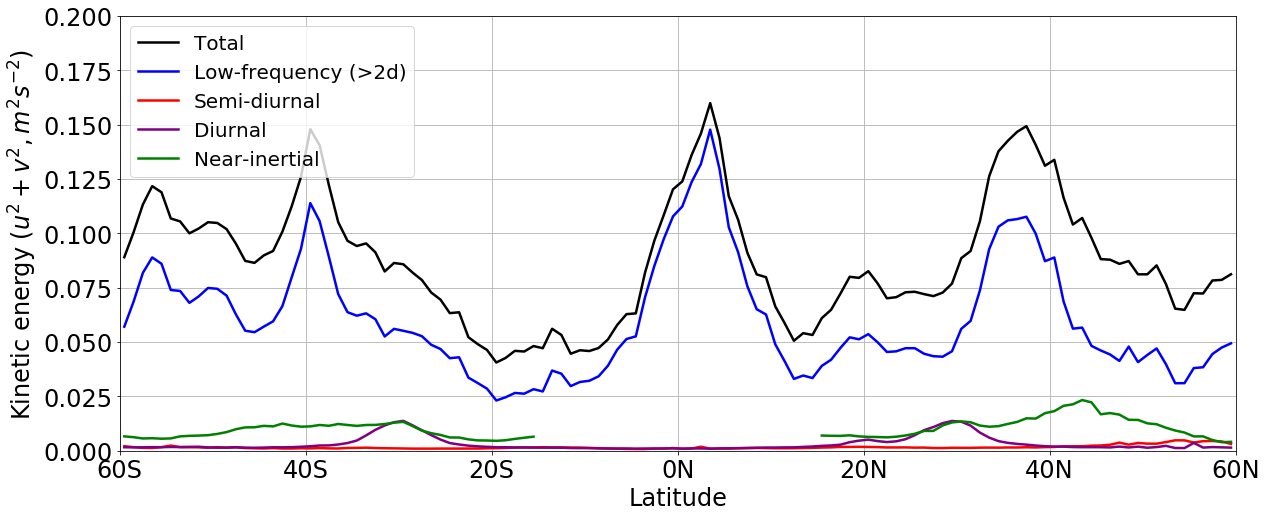

In [30]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E_drifters*df).sum(dim='freq').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_drifters.where((abs(E_drifters.freq_cpd)>0) & (abs(E_drifters.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_drifters.where((abs(E_drifters.freq_cpd)>1.9) & (abs(E_drifters.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifters.where((abs(E_drifters.freq_cpd)>0.9) & (abs(E_drifters.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E_drifters.where(abs(E_drifters.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq').where(abs(E_drifters.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.2])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_Drifters_2.png')


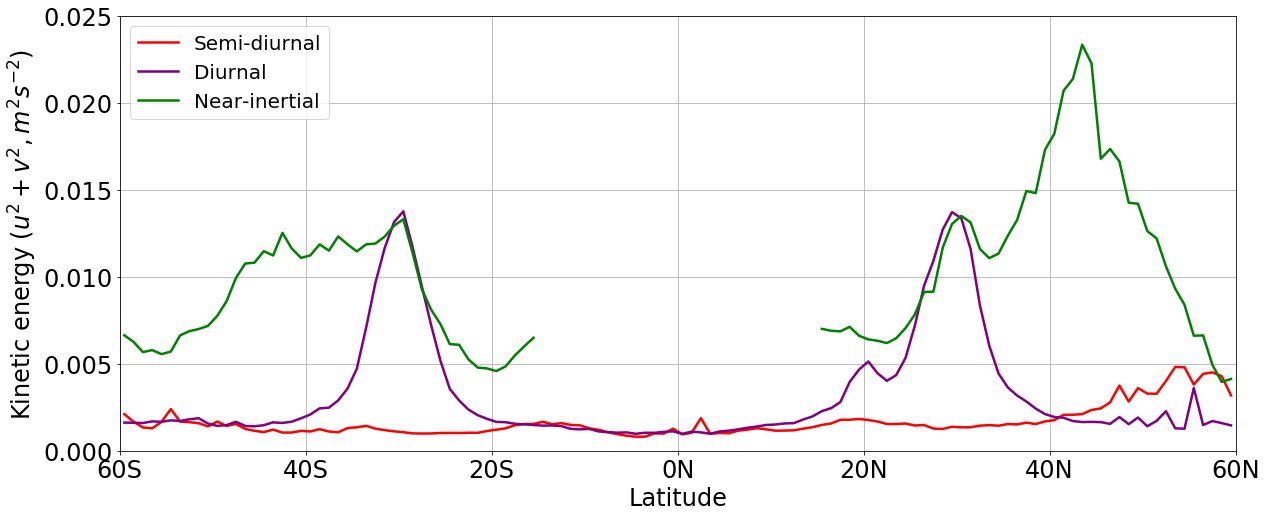

In [22]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E_drifters.where((abs(E_drifters.freq_cpd)>1.9) & (abs(E_drifters.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifters.where((abs(E_drifters.freq_cpd)>0.9) & (abs(E_drifters.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E_drifters.where(abs(E_drifters.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq').where(abs(E_drifters.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.025])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

In [116]:
f_welch = drifter_results['f'] # negative-freq spectra (unit: m^2 s^-2 cps)
f_welch = np.array(f_welch)
f_welch = xr.DataArray(f_welch*86400)
f_welch = xr.DataArray.squeeze(f_welch, dim='dim_0')
f_welch

<xarray.DataArray (dim_1: 720)>
array([ 0.016667,  0.033333,  0.05    , ..., 11.966667, 11.983333, 12.      ])
Dimensions without coordinates: dim_1

In [117]:
msac_welch = drifter_results['msac_welch'] # negative-freq spectra (unit: m^2 s^-2 cps)
msac_welch = np.array(msac_welch)
msac_welch = xr.DataArray(msac_welch)
msac_welch = xr.DataArray.squeeze(msac_welch, dim='dim_0')
msac_welch

<xarray.DataArray (dim_1: 720)>
array([1.275792e+04, 2.266140e+04, 2.321359e+04, ..., 1.603542e+01,
       1.631516e+01, 1.725849e+01])
Dimensions without coordinates: dim_1

In [118]:
msc_welch = drifter_results['msc_welch'] # negative-freq spectra (unit: m^2 s^-2 cps)
msc_welch = np.array(msc_welch)
msc_welch = xr.DataArray(msc_welch)
msc_welch = xr.DataArray.squeeze(msc_welch, dim='dim_0')
msc_welch

<xarray.DataArray (dim_1: 720)>
array([1.059169e+04, 1.773538e+04, 1.760040e+04, ..., 1.604783e+01,
       1.621803e+01, 1.708862e+01])
Dimensions without coordinates: dim_1

In [119]:
ds = xr.Dataset({'msac_welch': (['freq'], msac_welch),
                 'msc_welch': (['freq'], msc_welch)},
                 coords={'freq': (['freq'], f_welch)})
ds

<xarray.Dataset>
Dimensions:     (freq: 720)
Coordinates:
  * freq        (freq) float64 0.01667 0.03333 0.05 0.06667 0.08333 0.1 ...
Data variables:
    msac_welch  (freq) float64 1.276e+04 2.266e+04 2.321e+04 1.873e+04 ...
    msc_welch   (freq) float64 1.059e+04 1.774e+04 1.76e+04 1.399e+04 ...

In [120]:
msac_welch = ds.msac_welch
msc_welch = ds.msc_welch
msac_welch

<xarray.DataArray 'msac_welch' (freq: 720)>
array([1.275792e+04, 2.266140e+04, 2.321359e+04, ..., 1.603542e+01,
       1.631516e+01, 1.725849e+01])
Coordinates:
  * freq     (freq) float64 0.01667 0.03333 0.05 0.06667 0.08333 0.1 0.1167 ...

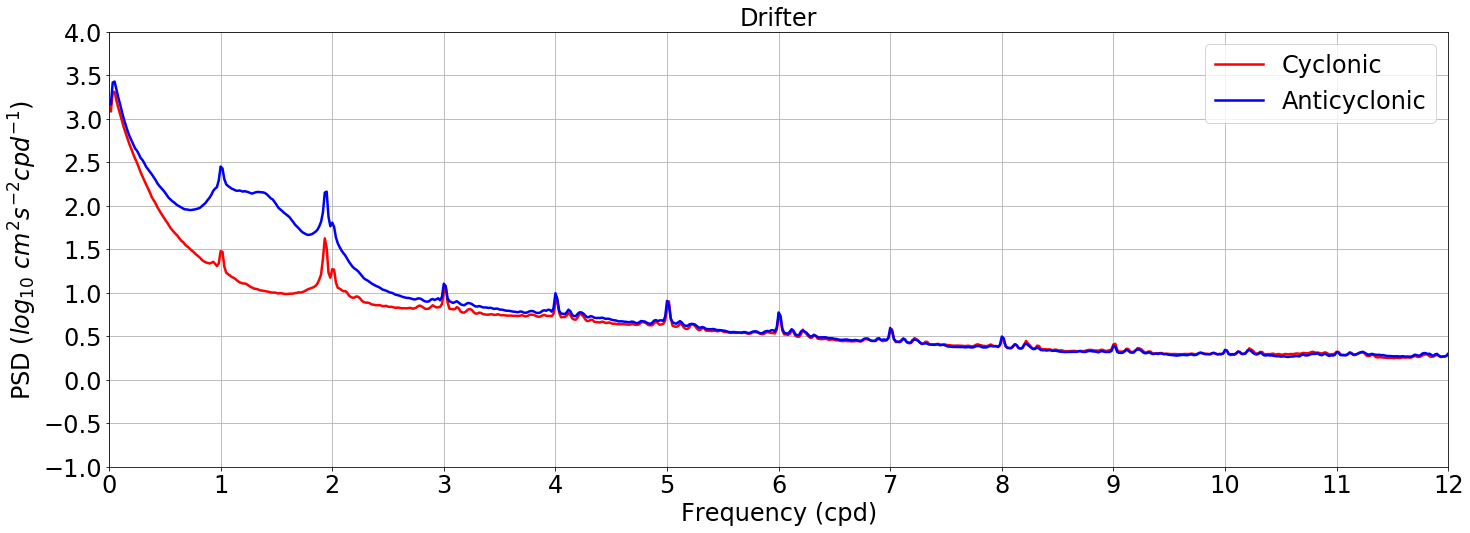

In [122]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

np.log10(msc_welch/8.64).plot(ax=ax,color='red', label=labels[0], linewidth=2.5)
(np.log10(msac_welch/8.64).where(msac_welch.freq>0)).plot(ax=ax,color='blue', label=labels[1], linewidth=2.5)

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifter',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_Drifter_3.png')

_______
# 2. LLC4320 results

In [123]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/'

D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
Dimensions without coordinates: face
Data variables:
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 60, 720)>


In [124]:
E_llc = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
print(E_llc)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


### open ocean

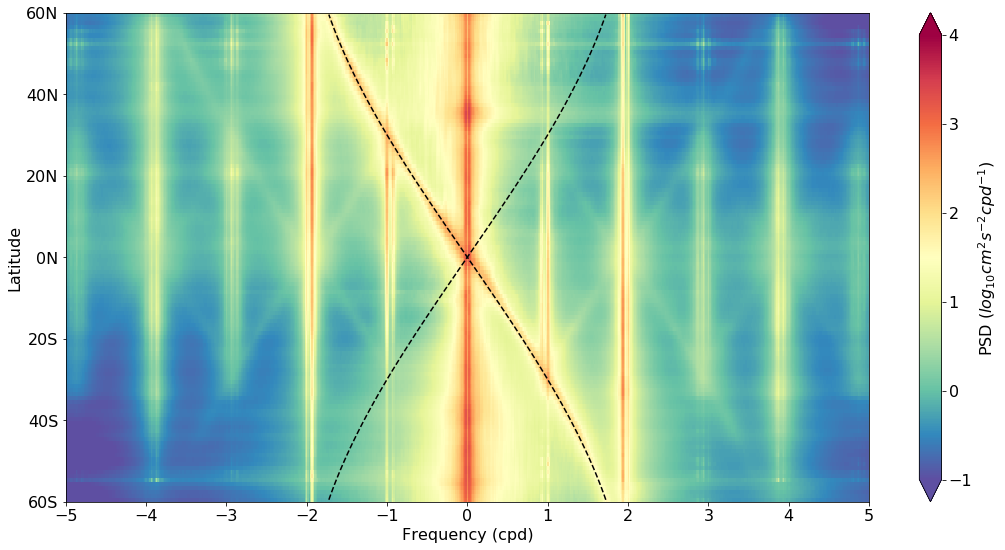

In [48]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
cax = np.log10(E_llc/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_llc.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_1.png')

## Band-frequency integral

In [49]:
E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
print(E_llc)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [50]:
df=E_llc.freq_time[1]-E_llc.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


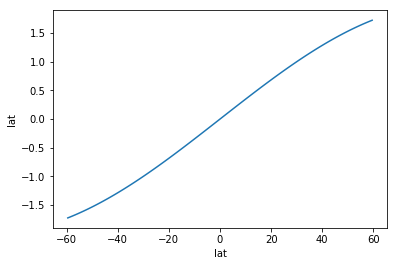

In [51]:
# Inertial frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_llc.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

## Total energy vs Band-frequency integral

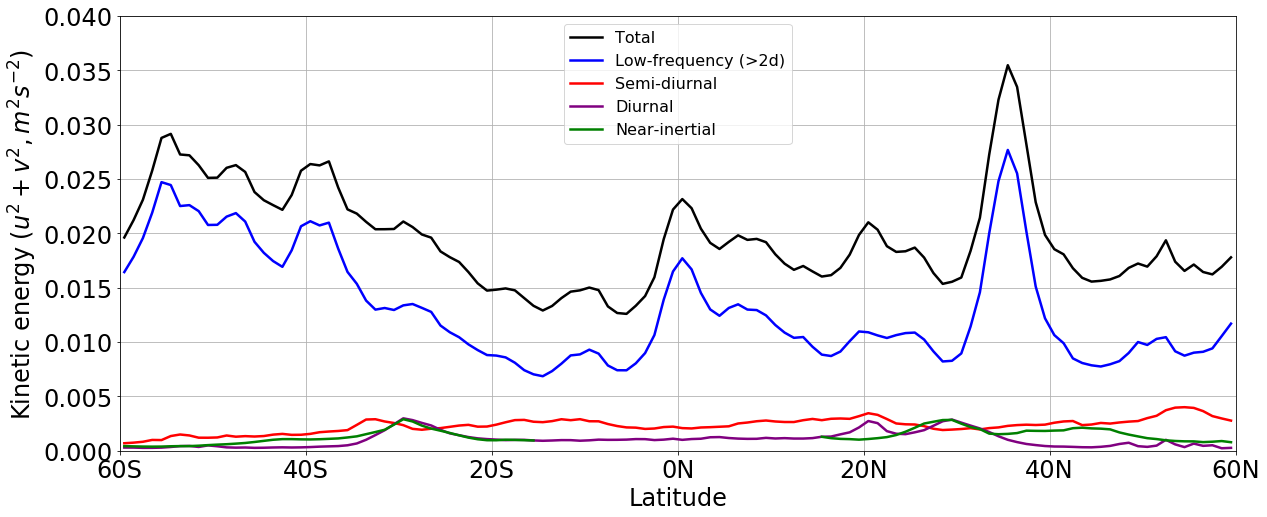

In [53]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E_llc*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_llc.where((abs(E_llc.freq_cpd)>0) & (abs(E_llc.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_llc.where((abs(E_llc.freq_cpd)>1.9) & (abs(E_llc.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_llc.where((abs(E_llc.freq_cpd)>0.9) & (abs(E_llc.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E_llc.where(abs(E_llc.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_llc.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 16}); 
ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.04])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_2.png')

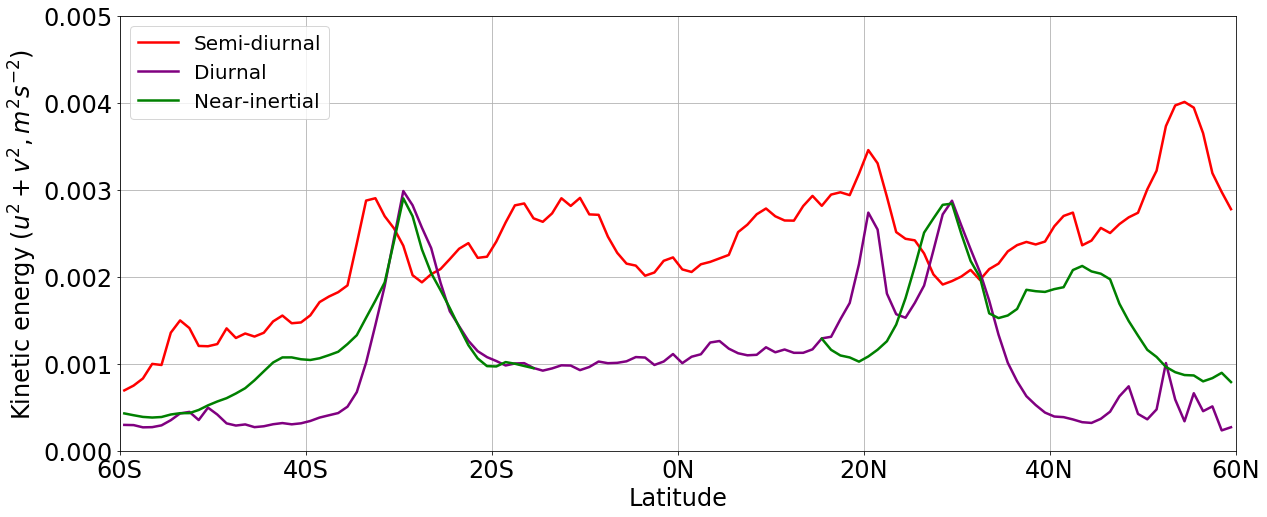

In [54]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E_llc.where((abs(E_llc.freq_cpd)>1.9) & (abs(E_llc.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_llc.where((abs(E_llc.freq_cpd)>0.9) & (abs(E_llc.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies
(E_llc.where(abs(E_llc.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_llc.lat)>15).plot(color='green', label=labels[4], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.005])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

In [32]:
(E_drifters*df).sum(dim=['freq','lat'])

<xarray.DataArray ()>
array(10.562962)

In [55]:
E_llc_all = (E_llc*df).sum(dim=['freq_time','lat'])
E_llc_all.values

array(2.35127765)

In [125]:
E_anti_all = xr.open_zarr(E_dir+'E_anti_all_openocean.zarr')
E_cycl_all = xr.open_zarr(E_dir+'E_cycl_all_openocean.zarr')

In [126]:
E_anti_all = E_anti_all.E_anti_all
E_cycl_all = E_cycl_all.E_cycl_all

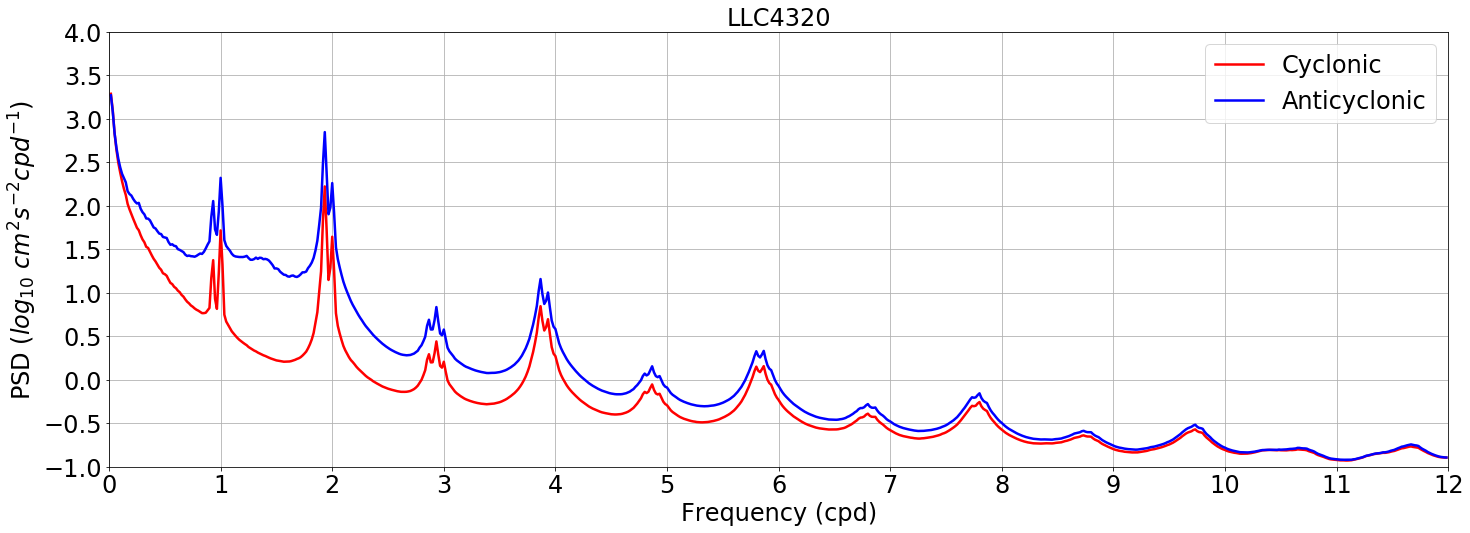

In [127]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax,color='red', label=labels[0], linewidth=2.5)
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax,color='blue', label=labels[1], linewidth=2.5)

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_3.png')

_______
# 3. Direct comparison

Text(0,0.5,'Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)')

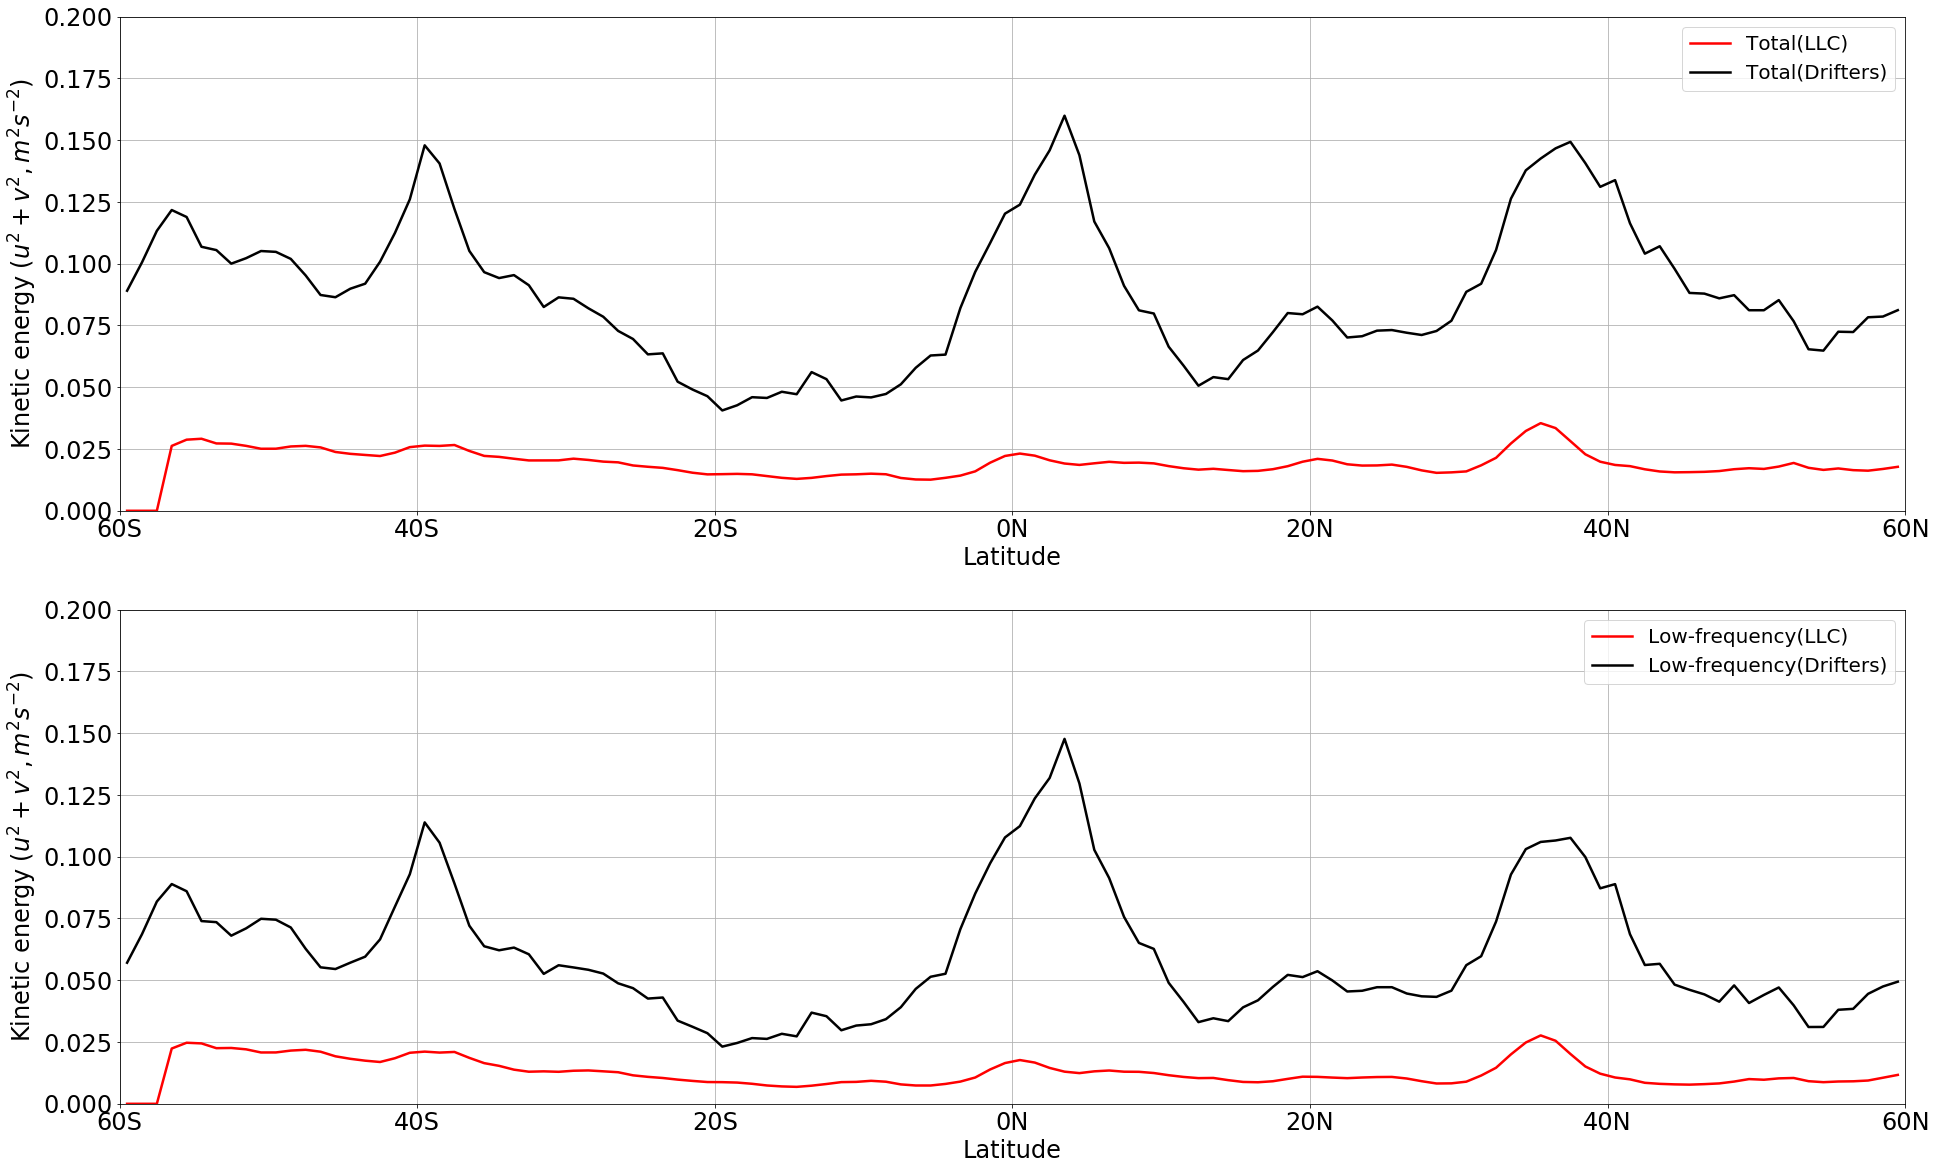

In [47]:
fig= plt.subplots(figsize=(32,20))

labels = ['Total(LLC)', 'Total(Drifters)', 'Low-frequency(LLC)','Low-frequency(Drifters)']

ax=plt.subplot(211)
(E_llc*df).sum(dim='freq_time').plot(color='red', label=labels[0], linewidth=2.5) # total energy
(E_drifters*df).sum(dim='freq').plot(color='black', label=labels[1], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)


ax=plt.subplot(212)
(E_llc.where((abs(E_llc.freq_cpd)>0) & (abs(E_llc.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_drifters.where((abs(E_drifters.freq_cpd)>0) & (abs(E_drifters.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq').plot(color='black', label=labels[3], linewidth=2.5)   # energy at low frequencies (> 5 days) 
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)


Text(0,0.5,'Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)')

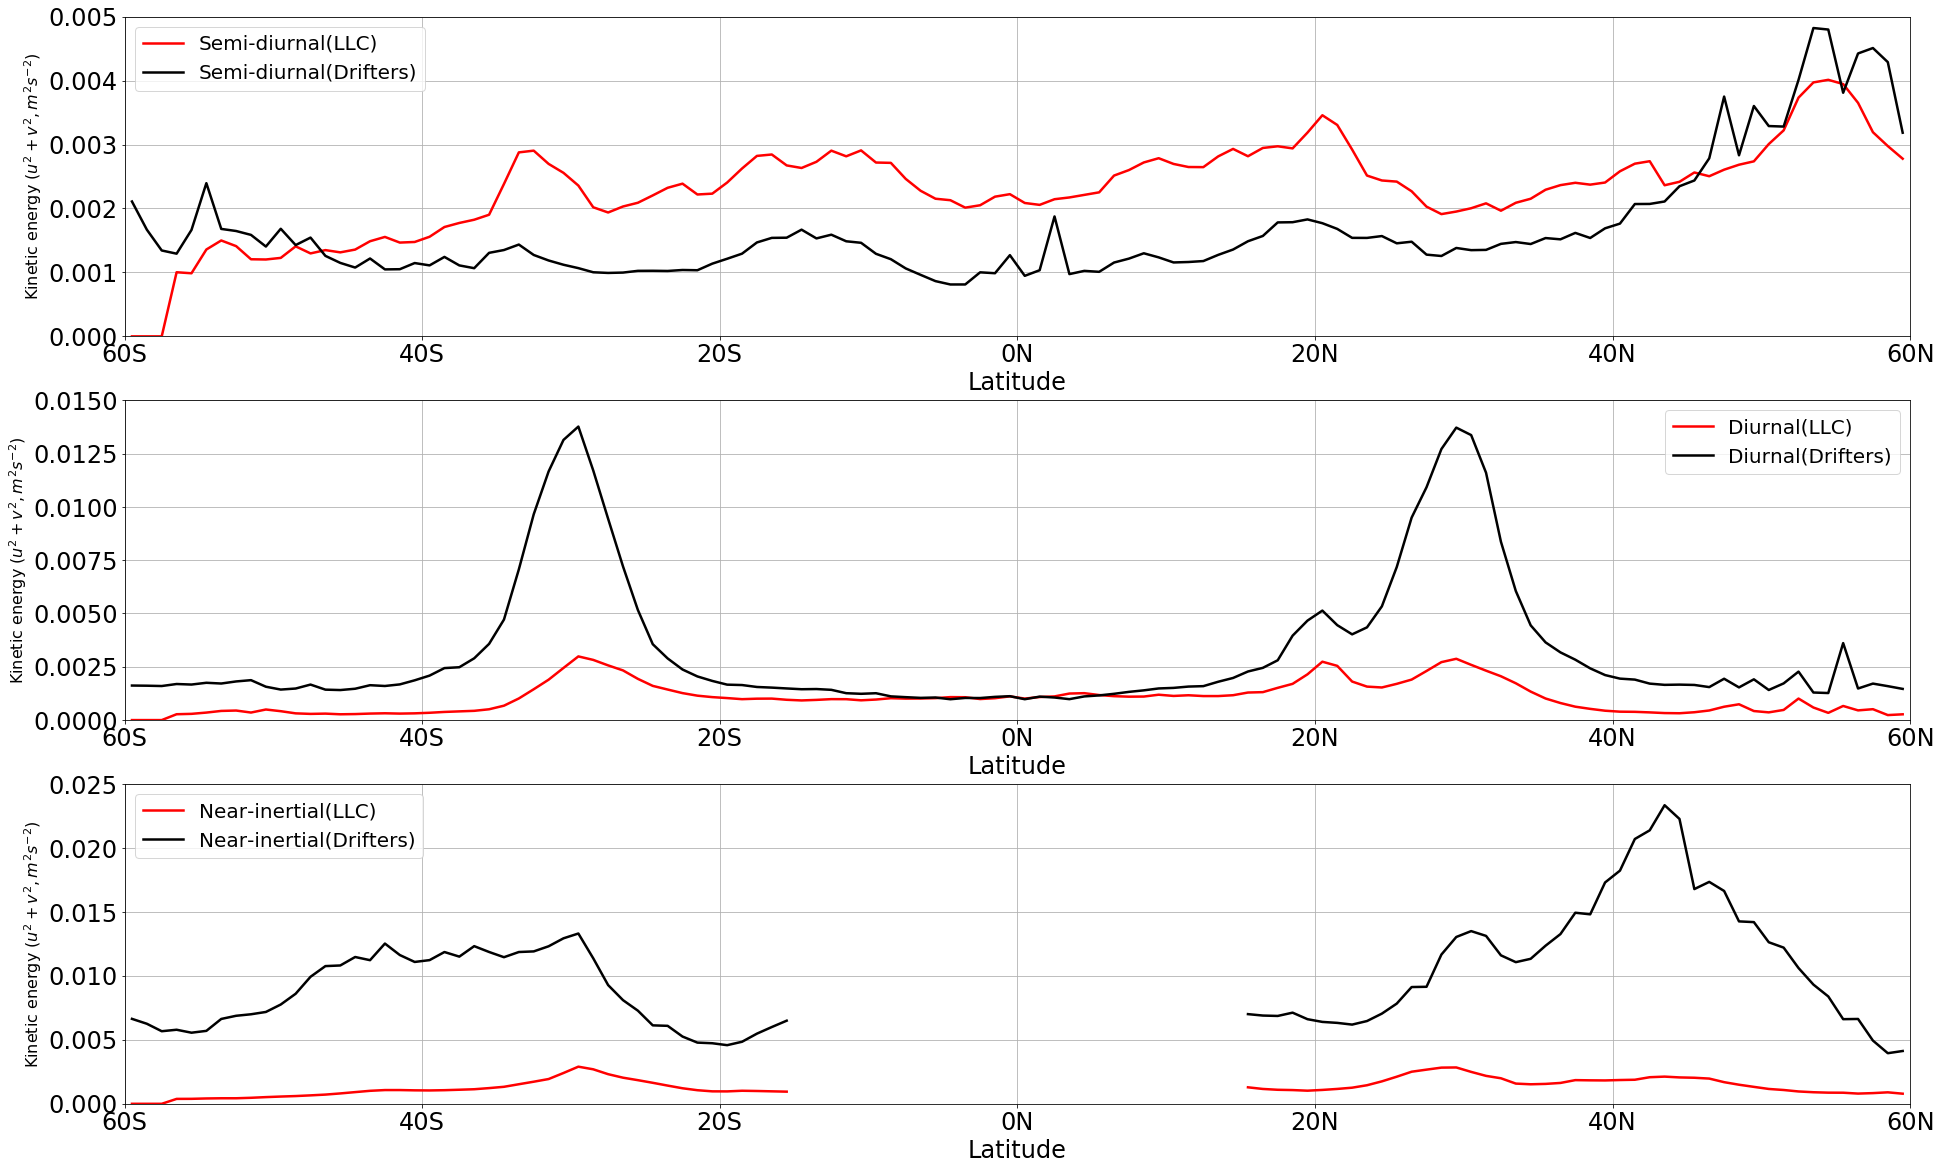

In [48]:
fig= plt.subplots(figsize=(32,20))

labels = ['Semi-diurnal(Drifters)', 'Diurnal(Drifters)', 'Near-inertial(Drifters)','Semi-diurnal(LLC)', 'Diurnal(LLC)', 'Near-inertial(LLC)']


ax=plt.subplot(311)
(E_llc.where((abs(E_llc.freq_cpd)>1.9) & (abs(E_llc.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifters.where((abs(E_drifters.freq_cpd)>1.9) & (abs(E_drifters.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq').plot(color='black', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.005])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=16)


ax=plt.subplot(312)
(E_llc.where((abs(E_llc.freq_cpd)>0.9) & (abs(E_llc.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
(E_drifters.where((abs(E_drifters.freq_cpd)>0.9) & (abs(E_drifters.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq').plot(color='black', label=labels[1], linewidth=2.5) # energy around diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.015])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=16)


ax=plt.subplot(313)
(E_llc.where(abs(E_llc.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_llc.lat)>15).plot(color='red', label=labels[5], linewidth=2.5) # energy around f
(E_drifters.where(abs(E_drifters.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq').where(abs(E_drifters.lat)>15).plot(color='black', label=labels[2], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.025])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=16)


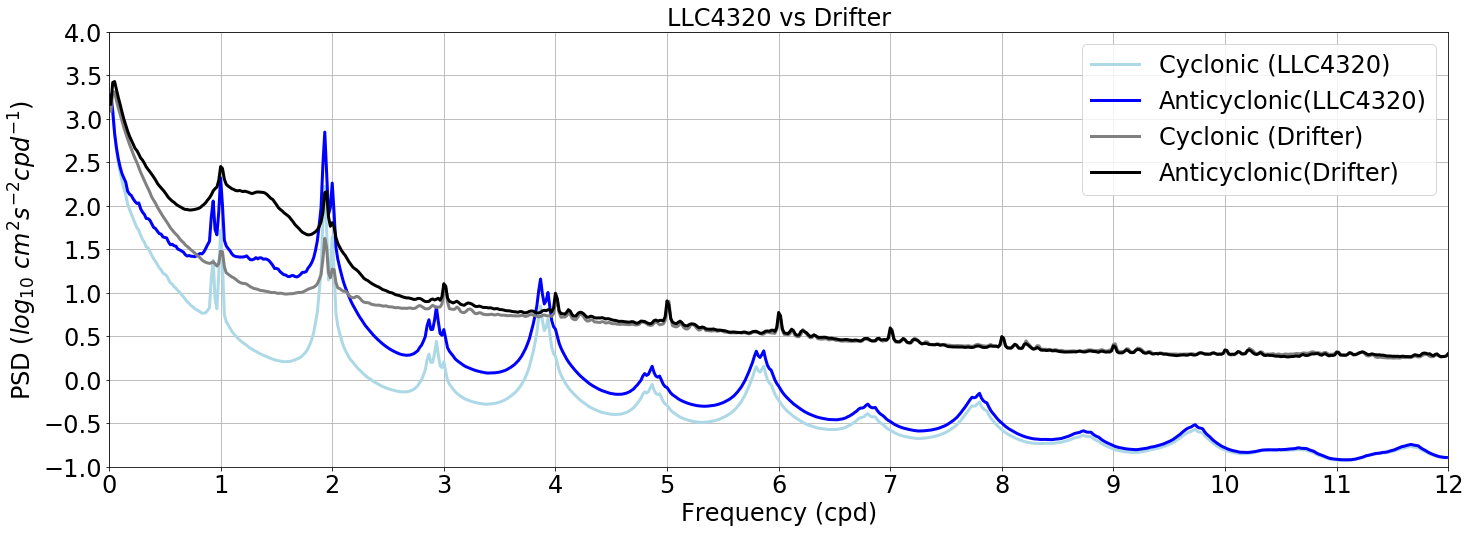

In [128]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic (LLC4320)', 'Anticyclonic(LLC4320)','Cyclonic (Drifter)', 'Anticyclonic(Drifter)']

(np.log10(E_cycl_all).where(E_cycl_all.freq_time>0)).plot(ax=ax, linewidth=3, color='lightblue', label=labels[0])
(np.log10(E_anti_all).where(E_anti_all.freq_time>0)).plot(ax=ax, linewidth=3, color='blue', label=labels[1])

np.log10(msc_welch/8.64).plot(ax=ax, linewidth=3, color='grey', label=labels[2])
(np.log10(msac_welch/8.64).where(msac_welch.freq>0)).plot(ax=ax, linewidth=3, color='black', label=labels[3])

ax.legend(); ax.grid()
#ax.set_yscale('log')
ax.set_ylim([-1.,4.])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])

ax.set_xlim([0.,12.])
#ax.set_ylim([1e-1,1e4])


ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs Drifter',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

In [130]:
cluster.scheduler.close()

<Future finished result=None>